In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

In [2]:
sns.set()

### 1.1 Récupérer le dataframe

In [4]:
df_propre = pd.read_csv("df_propre.csv")
df_propre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 25 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Country Name                                      126 non-null    object 
 1   GDP per capita (current US$)                      126 non-null    float64
 2   GDP growth (annual %)                             126 non-null    float64
 3   GNI per capita, Atlas method (current US$         126 non-null    float64
 4   Urban population (% of total population)          126 non-null    float64
 5   Access to electricity (% of population)           126 non-null    float64
 6   Individuals using the Internet (% of population)  126 non-null    float64
 7   population                                        126 non-null    float64
 8   stabilite_politique                               126 non-null    float64
 9   Export quantity_Meat 

In [5]:
#sélection de mes colonnes
colonnes_finales = [
    "log_gdp_per_capita",
    "Urban population (% of total population)",
    "stabilite_politique",
    "log_export_meat",
    "log_production_poultry",
    "prod_volaille_par_hab",
    "log_ratio_export_import",
    "indice_numerique"
]

X_final = df_propre[colonnes_finales].copy()

### 1.2 standardisation

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

### 1.3 ACP

In [9]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

### 1.3.1 variance expliqué

In [11]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio
variance_cumulee = np.cumsum(explained_variance_ratio)
variance_cumulee

df_variance = pd.DataFrame({
    "Composante": [f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    "Variance expliquée (%)": explained_variance_ratio * 100,
    "Variance cumulée (%)": variance_cumulee * 100
})
print(df_variance)

  Composante  Variance expliquée (%)  Variance cumulée (%)
0        PC1               51.466235             51.466235
1        PC2               19.990654             71.456889
2        PC3               11.604303             83.061192
3        PC4                6.607366             89.668558
4        PC5                4.481896             94.150454
5        PC6                2.494291             96.644745
6        PC7                2.258170             98.902915
7        PC8                1.097085            100.000000


### 1.3.2 affichage graphique de la variance expliqué

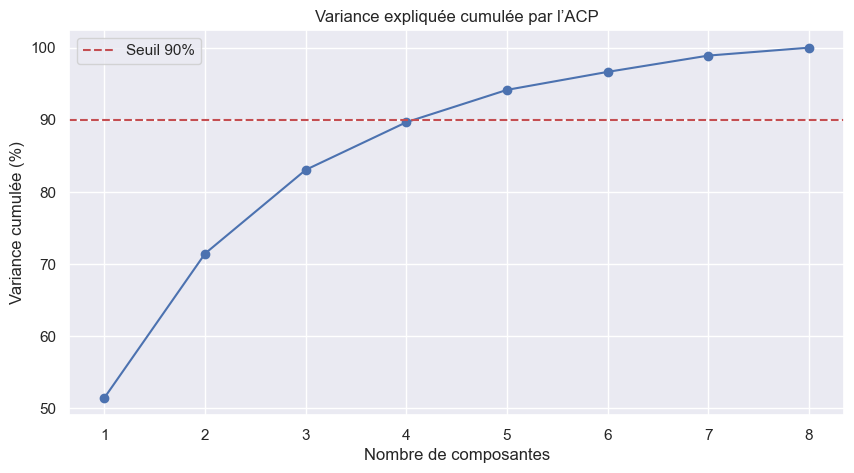

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), variance_cumulee * 100, marker='o')
plt.axhline(y=90, color='r', linestyle='--', label='Seuil 90%')
# seuil pour : 
# une ACP en 2D : 60 à 70%
# Réduction des dimensions (analyse) : >80%
# Réduction forte (modèle prédictif) : > 90%
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée (%)')
plt.title('Variance expliquée cumulée par l’ACP')
plt.grid(True)
plt.legend()
plt.show()

### 1.3.3 Ebouli

In [15]:
# Variance expliquée par composante
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()



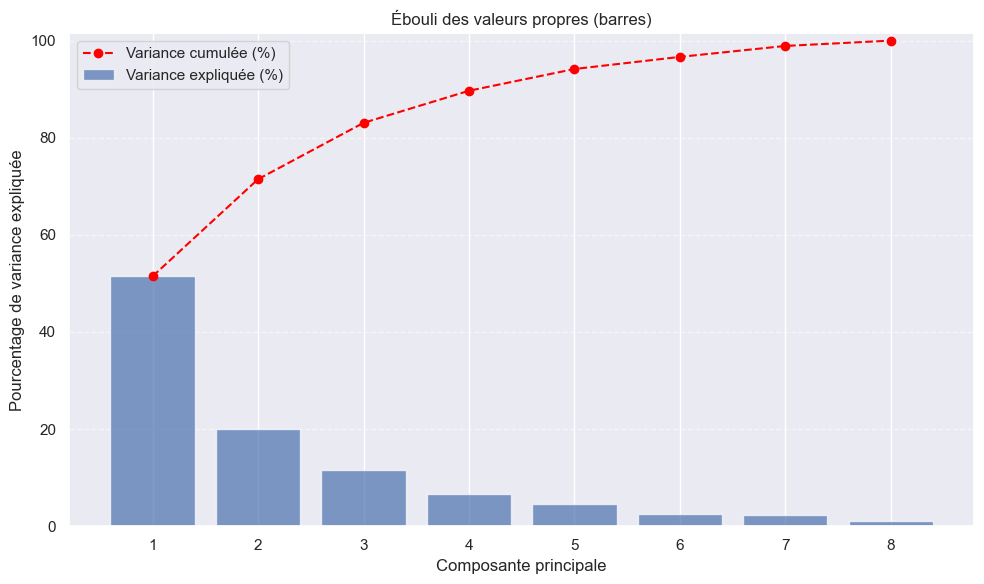

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_var) + 1), explained_var * 100, alpha=0.7, label="Variance expliquée (%)")
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var * 100, marker='o', color='red', linestyle='--', label="Variance cumulée (%)")

plt.xlabel("Composante principale")
plt.ylabel("Pourcentage de variance expliquée")
plt.title("Ébouli des valeurs propres (barres)")
plt.xticks(range(1, len(explained_var) + 1))
plt.ylim(0, max(explained_var) * 100 + 50)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 1.3.4 Méthode du coude

In [18]:
!pip install kneed

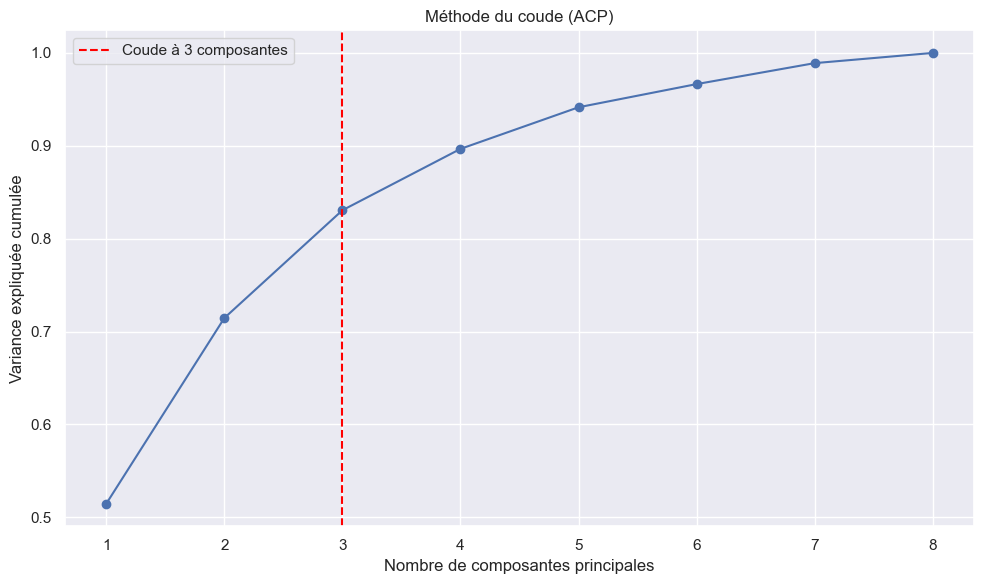

In [19]:
from kneed import KneeLocator

explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le "coude" automatiquement
knee = KneeLocator(
    range(1, len(explained_variance) + 1),
    explained_variance,
    curve="concave",
    direction="increasing"
)

# Eboulie avec le coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axvline(x=knee.knee, color='red', linestyle='--', label=f"Coude à {knee.knee} composantes")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.title("Méthode du coude (ACP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### la methode du coude permet de voir que 3 composantes suffisent pour avoir une bonne vision mais dans notre cas nous allons pousser à 4 afin d,avoir encore plus de precision

### 1.4 Nuage des individus (4 composantes)

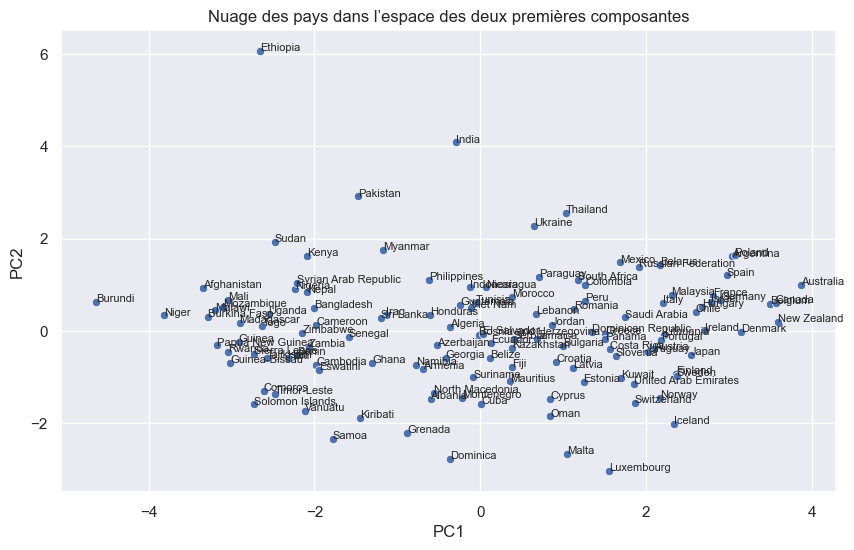

In [22]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
df_pca["Pays"] = df_propre["Country Name"]  

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2")
for i in range(len(df_pca)):
    plt.text(df_pca['PC1'][i], df_pca['PC2'][i], df_pca['Pays'][i], fontsize=8)
plt.title("Nuage des pays dans l’espace des deux premières composantes")
plt.grid(True)
plt.show()

## on remarque que nos pays sont plutot regroupés avec sur la droite des pays plutot riches, sur la gauche plutot faible. En bas des petits pays avec une faible production et en haut des grand pays avec une grande production

In [24]:
import plotly.express as px

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
df_pca["Country Name"] = df_propre["Country Name"].values

fig = px.scatter_3d(
    df_pca,
    x="PC1", y="PC2", z="PC3",
    color="PC1", 
    hover_name="Country Name",
    title="Nuage des pays projeté sur PC1 - PC2 - PC3 (ACP)"
)

fig.update_layout(scene=dict(
    xaxis_title=f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
    yaxis_title=f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
    zaxis_title=f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)"
))
fig.show()

### 1.5 cercle des correlations

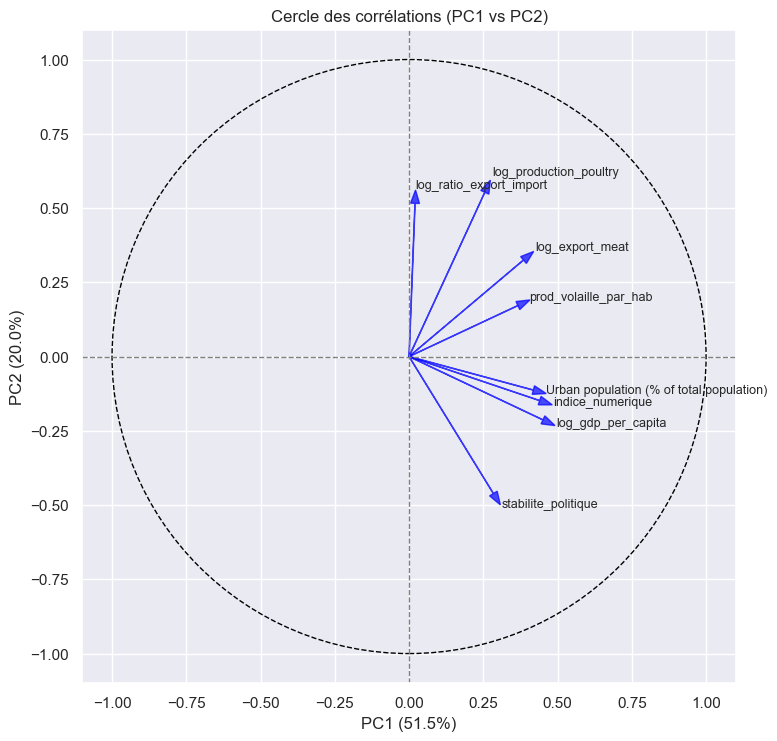

In [28]:


 
pcs = pca.components_  
features = X_final.columns
n_comp = pca.n_components_

# Création du cercle
plt.figure(figsize=(8, 8))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Cercle unité
circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='black', linestyle='--')
plt.gca().add_patch(circle)

# Vecteurs des variables
for i in range(len(features)):
    plt.arrow(0, 0,
              pcs[0, i], pcs[1, i],
              color='blue', alpha=0.7, head_width=0.03)
    plt.text(pcs[0, i]*1.1, pcs[1, i]*1.1,
             features[i], fontsize=9)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Cercle des corrélations (PC1 vs PC2)")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


## Via ce cercle de correlation on voit que PC1 est avant tout composé du PIB par habitant et de l'indice du developpement numérique
## PC2 quand a lui correpond à la production de volaille et du ratio import export

## exemple de description pondérée : PC1 est moyennenement corrélé au log du PIB par habitant et très très faiblement corrélé avec le log du ratio import export

# 1.5.2 Cercle de corelation PC3 et PC4

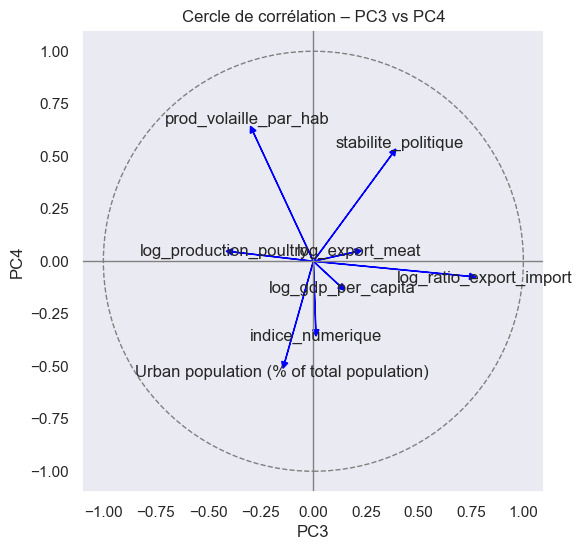

In [31]:
pca = PCA(n_components=4)  
X_scaled = StandardScaler().fit_transform(X_final)
pca.fit(X_scaled)

pcs = pca.components_
var_names = X_final.columns  # noms des variables initiales

# Création du cercle
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel("PC3")
ax.set_ylabel("PC4")
ax.set_title("Cercle de corrélation – PC3 vs PC4")

# Cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

# Tracer les flèches
for i in range(len(var_names)):
    x = pcs[2, i]  # PC3
    y = pcs[3, i]  # PC4
    ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='blue', ec='blue')
    ax.text(x * 1.1, y * 1.1, var_names[i], ha='center', va='center')

# Grille et aspect carré
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)
ax.set_aspect('equal')
plt.grid()
plt.show()

## PC3 correspond principalement au ratio d'import export opposé à la production de volaille dans un pays stable
## PC4 à la production de voilaille par habitant dans un pays stable avec une population rurale

### 1.6 Contribution des variables

In [34]:
pd.DataFrame(pca.components_.T, index=X_final.columns, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

PC1       PC2       PC3  \
log_gdp_per_capita                        0.450735 -0.213225  0.126533   
Urban population (% of total population)  0.418345 -0.112875 -0.136361   
stabilite_politique                       0.283874 -0.461199  0.375156   
log_export_meat                           0.385264  0.325007  0.199908   
log_production_poultry                    0.255022  0.553014 -0.385669   
prod_volaille_par_hab                     0.366278  0.171651 -0.286836   
log_ratio_export_import                   0.020033  0.515917  0.744005   
indice_numerique                          0.439563 -0.148330  0.011396   

                                               PC4  
log_gdp_per_capita                       -0.117440  
Urban population (% of total population) -0.480752  
stabilite_politique                       0.510421  
log_export_meat                           0.044547  
log_production_poultry                    0.044679  
prod_volaille_par_hab                     0.615570  
log_ratio_export_import                  -0.072004  
indice_numerique                         -0.326289

# PC1 dévoloppement économique et numérique global
# PC2 Profil d'exportateur Agricole(viande/volaille)
# PC3 déséquilibre export import + stabilité
# PC4 Pays ruraux très producteurs et stable

# 1.7 CAH

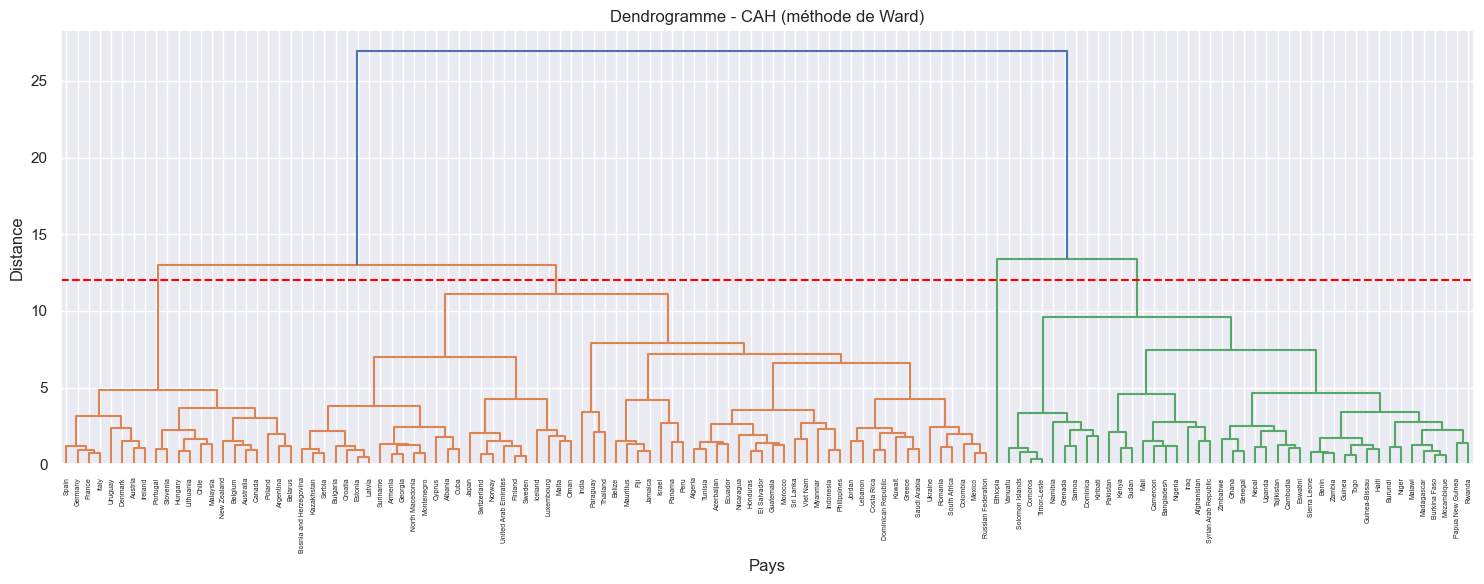

In [118]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# 1. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# 2. CAH - calcul des distances et linkage (méthode de Ward)
Z = linkage(X_scaled, method='ward')

# 2.1 création du seuil de coupe
distance_seuil = 12

# 3. Affichage du dendrogramme
plt.figure(figsize=(15, 6))
dendrogram(Z, labels=df_propre["Country Name"].values, leaf_rotation=90)
plt.axhline(y=distance_seuil, color='red', linestyle='--', label='Seuil de coupe')
plt.title("Dendrogramme - CAH (méthode de Ward)")
plt.xlabel("Pays")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# 4. Création des clusters (ex: 4 groupes)
nb_clusters = 4
cluster_labels = fcluster(Z, nb_clusters, criterion='maxclust')

# 5. Ajout au dataframe
df_propre["Cluster_CAH"] = cluster_labels


# on identifie clairement 2 groupes et l'on peut pousser à 3 groupes

### 1.8 Méthode du coude

C:\Users\gabry\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\gabry\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\gabry\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\gabry\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

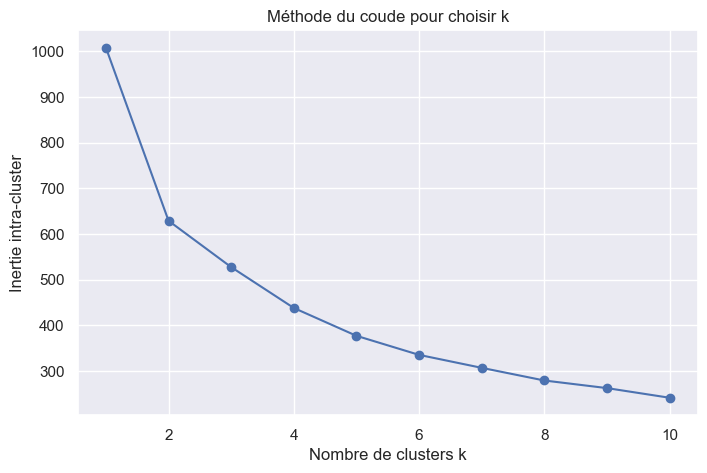

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)  # X_pca ou X_scaled, ou X_final selon ton usage
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Nombre de clusters k")
plt.ylabel("Inertie intra-cluster")
plt.title("Méthode du coude pour choisir k")
plt.grid(True)
plt.show()


### 1.9 Clustering k-means

C:\Users\gabry\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



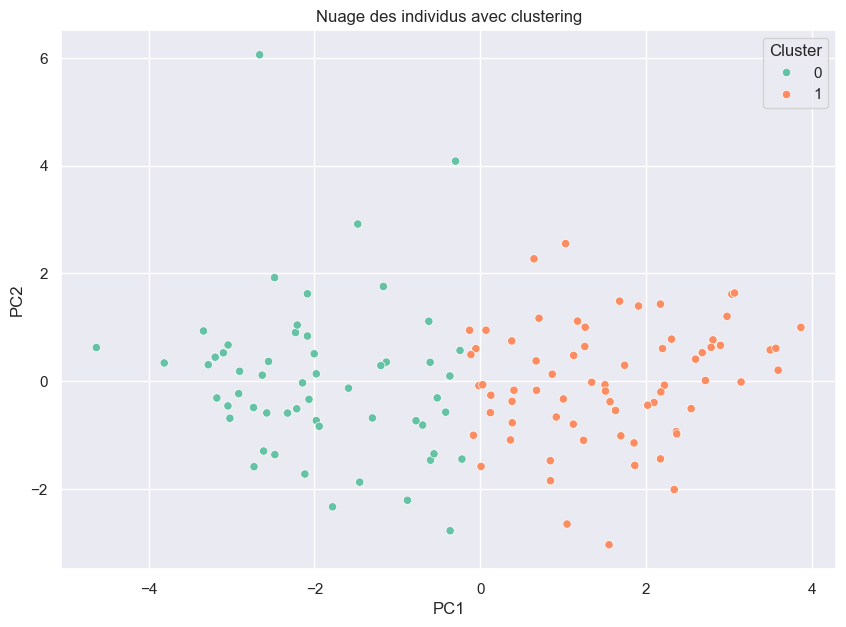

In [42]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(X_pca)

# Visualisation des clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title("Nuage des individus avec clustering")
plt.grid(True)
plt.show()


C:\Users\gabry\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



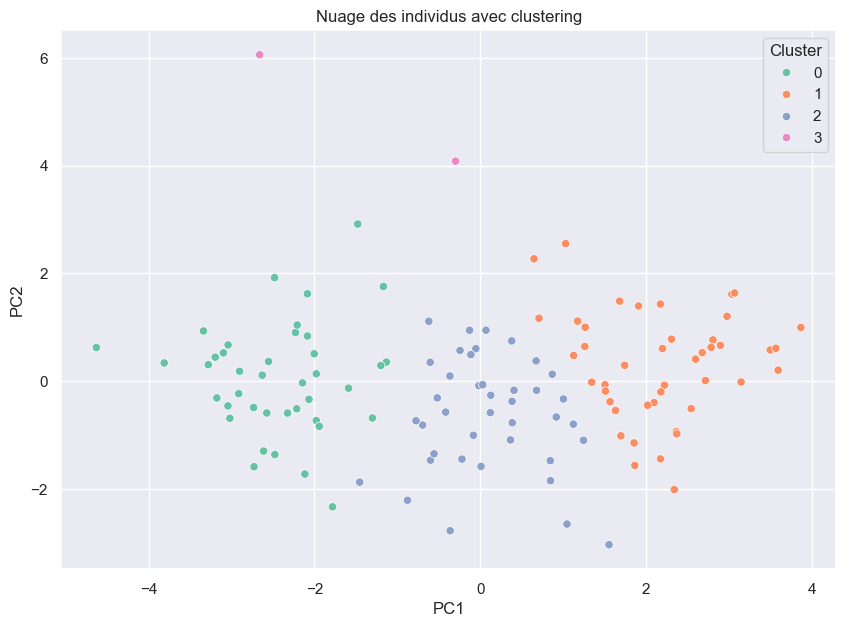

In [43]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(X_pca)

# Visualisation des clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title("Nuage des individus avec clustering")
plt.grid(True)
plt.show()

# 1.10 choix du cluster

## score ARI

In [46]:
from sklearn.metrics import adjusted_rand_score


labels_kmeans = df_pca["Cluster"]
labels_cah = df_propre["Cluster_CAH"]  

ari = adjusted_rand_score(labels_kmeans, labels_cah)
print(f"Adjusted Rand Index (ARI) entre CAH et K-means : {ari:.3f}")

Adjusted Rand Index (ARI) entre CAH et K-means : 0.480


In [47]:
# les clusters du Kmeans et du CAH sont moyennement similaires

## silhouette score

In [49]:
from sklearn.metrics import silhouette_score

# X_pca : les données utilisées pour le clustering
# labels_kmeans ou labels_cah : les étiquettes de cluster obtenues via KMeans ou cah

score = silhouette_score(X_pca, labels_kmeans)
print(f"Silhouette Score k-means : {score:.3f}")

Silhouette Score k-means : 0.333


In [50]:
score = silhouette_score(X_pca, labels_cah)
print(f"Silhouette Score CAH : {score:.3f}")

Silhouette Score CAH : 0.282


### ces resultat de silhouette score entre 0.25 et 0.5 indiquent une structure des clusters faible mais exploitable. Si le score avait été à 1 alors le clustering est très bien séparé.  Un score plus bas pour le CAH nous indique que le regroupement hierarchique forcent des rapprochement moins naturel dans les données

# nous allons préférer le clustering par la méthode du k-means

# 2 test clustering

In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Étape 1 : Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)  

# Étape 2 : ACP sur 4 composantes
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Étape 3 : Création du DataFrame PCA
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])

# Étape 4 : Ajout des noms de pays
df_pca["Country Name"] = df_propre["Country Name"].values 

# Étape 5 : KMeans clustering sur les 4 composantes
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df_pca["Cluster"] = clusters

# Étape 6 : Vérification du DataFrame final
print(df_pca.head())        # Affiche les premières lignes
print(df_pca.columns)       # Vérifie les noms de colonnes
print(df_pca.shape)         # Vérifie le nombre de lignes et colonnes


        PC1       PC2       PC3       PC4          Country Name  Cluster
0 -3.338815  0.932534 -1.116583 -1.087976           Afghanistan        0
1 -0.599226 -1.465524  0.252225 -0.428644               Albania        2
2  1.856563 -1.145231  0.492181 -1.098731  United Arab Emirates        1
3  3.037543  1.615960 -0.133999  0.399134             Argentina        1
4 -0.694249 -0.813971 -0.013558 -1.077559               Armenia        2
Index(['PC1', 'PC2', 'PC3', 'PC4', 'Country Name', 'Cluster'], dtype='object')
(126, 6)


C:\Users\gabry\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



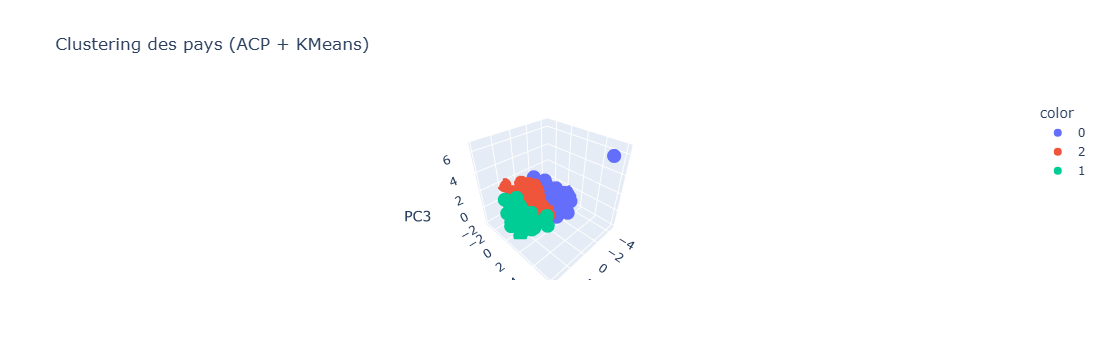

In [54]:
import plotly.express as px

fig = px.scatter_3d(
    df_pca, x="PC1", y="PC2", z="PC3",
    color=df_pca["Cluster"].astype(str),  # couleur par cluster
    hover_name="Country Name",
    title="Clustering des pays (ACP + KMeans)"
)
fig.show()


# 2.1 Nommer les clusters

# Je vais chercher des détails et des pondérations pour m'aider à nommer les clusters

In [57]:
#Moyenne des variables par cluster
df_clustered = X_final.copy()
df_clustered["Cluster"] = clusters


df_summary = df_clustered.groupby("Cluster").mean(numeric_only=True)
display(df_summary)

log_gdp_per_capita  Urban population (% of total population)  \
Cluster                                                                 
0                  7.071475                                 31.620050   
1                  9.987282                                 77.259810   
2                  8.797590                                 63.184682   

         stabilite_politique  log_export_meat  log_production_poultry  \
Cluster                                                                 
0                  -0.757745         0.730919                3.563830   
1                   0.370290         5.130176                6.126175   
2                   0.011816         1.922136                3.857824   

         prod_volaille_par_hab  log_ratio_export_import  indice_numerique  
Cluster                                                                    
0                     0.003322                 0.924694         37.531106  
1                     0.032230                 0.810784         88.567857  
2                     0.014233                 0.277456         78.194318

In [58]:
# Mise en couleur du tableau top /flop
def highlight_max_min(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else 
            'background-color: lightcoral' if w else '' 
            for v, w in zip(is_max, is_min)]

styled_df = df_summary.style.apply(highlight_max_min, axis=0).format(precision=3)

styled_df


In [59]:
#moyenne des variables par cluster + autres datas intelligibles

df_clustered_int = df_propre.copy()
df_clustered_int["Cluster"] = clusters


df_summary = df_clustered_int.groupby("Cluster").mean(numeric_only=True)
display(df_summary)


GDP per capita (current US$)  GDP growth (annual %)  \
Cluster                                                        
0                         1463.639255               4.326582   
1                        29804.219597               3.140559   
2                        10384.222298               3.142264   

         GNI per capita, Atlas method (current US$  \
Cluster                                              
0                                      1362.250000   
1                                     27993.095238   
2                                      9173.409091   

         Urban population (% of total population)  \
Cluster                                             
0                                       31.620050   
1                                       77.259810   
2                                       63.184682   

         Access to electricity (% of population)  \
Cluster                                            
0                                      55.170000   
1                                      99.264286   
2                                      96.347727   

         Individuals using the Internet (% of population)    population  \
Cluster                                                                   
0                                               19.892213  6.660816e+07   
1                                               77.871429  3.100801e+07   
2                                               60.040909  1.825962e+07   

         stabilite_politique  Export quantity_Meat  \
Cluster                                              
0                  -0.757745             36.750000   
1                   0.370290            612.285714   
2                   0.011816             23.090909   

         Export quantity_Poultry Meat  ...  Production_Poultry Meat  \
Cluster                                ...                            
0                            0.350000  ...               222.800000   
1                          146.238095  ...               928.738095   
2                            4.659091  ...               210.977273   

         Organic area share of total farmland [%]  prod_volaille_par_hab  \
Cluster                                                                    
0                                        1.816500               0.003322   
1                                        5.081190               0.032230   
2                                        1.704773               0.014233   

         ratio_export_import_viande  indice_numerique  \
Cluster                                                 
0                     450035.059353         37.531106   
1                          2.605229         88.567857   
2                          1.670868         78.194318   

         log_ratio_export_import  log_gdp_per_capita  log_export_meat  \
Cluster                                                                 
0                       0.924694            7.071475         0.730919   
1                       0.810784            9.987282         5.130176   
2                       0.277456            8.797590         1.922136   

         log_production_poultry  Cluster_CAH  
Cluster                                       
0                      3.563830     2.950000  
1                      6.126175     1.500000  
2                      3.857824     2.136364  

[3 rows x 25 columns]

In [60]:
def highlight_max_min(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else 
            'background-color: lightcoral' if w else '' 
            for v, w in zip(is_max, is_min)]

styled_df = df_summary.style.apply(highlight_max_min, axis=0).format(precision=3)

styled_df

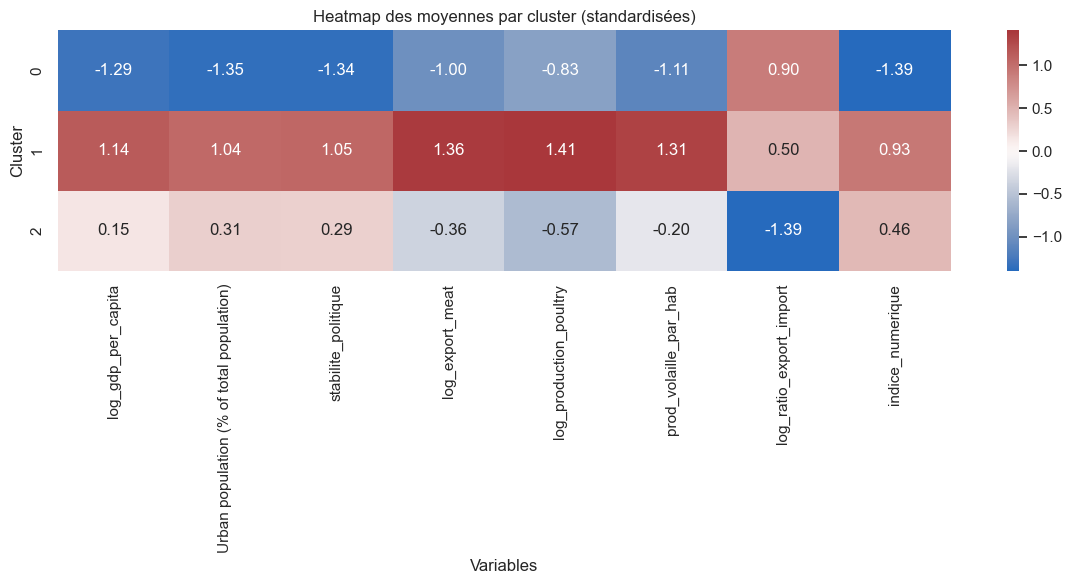

In [61]:
# heat map des clusters
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Étape 1 : Grouper par cluster et faire la moyenne
df_heatmap = df_propre.copy()
df_heatmap["Cluster"] = df_pca["Cluster"].values  # Assure-toi que les index sont alignés

# On garde uniquement les variables numériques (sauf 'Country Name')
cols_features = [
    "log_gdp_per_capita",
    "Urban population (% of total population)",
    "stabilite_politique",
    "log_export_meat",
    "log_production_poultry",
    "prod_volaille_par_hab",
    "log_ratio_export_import",
    "indice_numerique"
]

cluster_means = df_heatmap.groupby("Cluster")[cols_features].mean()

# Étape 2 : Standardiser les moyennes pour bonne échelle visuelle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Étape 3 : Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means_scaled, annot=True, cmap="vlag", center=0, fmt=".2f")
plt.title("Heatmap des moyennes par cluster (standardisées)")
plt.ylabel("Cluster")
plt.xlabel("Variables")
plt.tight_layout()
plt.show()


In [62]:
#nombre de pays par cluster
df_clustered["Cluster"].value_counts()


Cluster
2    44
1    42
0    40
Name: count, dtype: int64

### cluster 0 : pays à faible stabilité ou marché saturé, faible pouvoir d'achat (priorité faible)
### Cluster 1 : pays à haut revenu, stable politiquement, bon accès numérique, forte production locale (intéressant pour partenariat ou transformation locale)
### cluster 2 : pays emergents, bonne croissance, faible production de volaille, marché à développer (opportunité pour l'export)

# 2.2 Nommer les clusters approches centroides

# definition des clusters, approche par les centroides

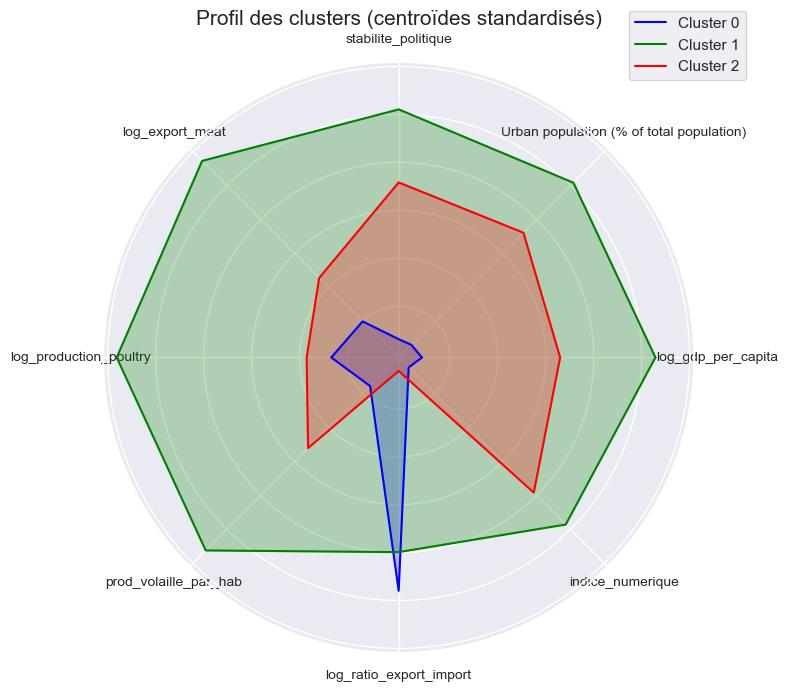

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# moyennes des clusters
centroids = df_propre.copy()
centroids["Cluster"] = df_pca["Cluster"].values

# Moyenne des variables par cluster
cols_features = [
    "log_gdp_per_capita",
    "Urban population (% of total population)",
    "stabilite_politique",
    "log_export_meat",
    "log_production_poultry",
    "prod_volaille_par_hab",
    "log_ratio_export_import",
    "indice_numerique"
]
df_summary = centroids.groupby("Cluster")[cols_features].mean()

# Standardisation pour rendre les variables comparables visuellement
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_summary),
    columns=df_summary.columns,
    index=df_summary.index
)

# Préparer les angles pour le radar plot
labels = df_scaled.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # boucle pour revenir au point de départ

# Radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Tracer un cluster à la fois
colors = ['blue', 'green', 'red']
for i, row in df_scaled.iterrows():
    values = row.tolist()
    values += values[:1]  # pour fermer le cercle
    ax.plot(angles, values, label=f'Cluster {i}', color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

# Réglages
ax.set_title("Profil des clusters (centroïdes standardisés)", size=15)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.tight_layout()
plt.show()


# 2.3 Détails et visulations des clusters

In [68]:
df_propre["Cluster"] = clusters
# Extraire la liste des pays par cluster
cluster_pays_dict = df_propre.groupby("Cluster")["Country Name"].apply(list).to_dict()

# Afficher proprement
for cluster, pays in cluster_pays_dict.items():
    print(f"\nCluster {cluster} ({len(pays)} pays) :")
    for p in pays:
        print(f" - {p}")



Cluster 0 (40 pays) :
 - Afghanistan
 - Burundi
 - Benin
 - Burkina Faso
 - Bangladesh
 - Cameroon
 - Comoros
 - Ethiopia
 - Guinea
 - Guinea-Bissau
 - Haiti
 - India
 - Kenya
 - Cambodia
 - Sri Lanka
 - Madagascar
 - Mali
 - Myanmar
 - Mozambique
 - Malawi
 - Niger
 - Nigeria
 - Nepal
 - Pakistan
 - Papua New Guinea
 - Rwanda
 - Sudan
 - Senegal
 - Solomon Islands
 - Sierra Leone
 - Eswatini
 - Syrian Arab Republic
 - Togo
 - Tajikistan
 - Timor-Leste
 - Uganda
 - Vanuatu
 - Samoa
 - Zambia
 - Zimbabwe

Cluster 1 (42 pays) :
 - United Arab Emirates
 - Argentina
 - Australia
 - Austria
 - Belgium
 - Belarus
 - Canada
 - Switzerland
 - Chile
 - Colombia
 - Costa Rica
 - Germany
 - Denmark
 - Dominican Republic
 - Spain
 - Finland
 - France
 - Greece
 - Hungary
 - Ireland
 - Iceland
 - Israel
 - Italy
 - Japan
 - Lithuania
 - Mexico
 - Malaysia
 - Norway
 - New Zealand
 - Panama
 - Peru
 - Poland
 - Portugal
 - Romania
 - Russian Federation
 - Saudi Arabia
 - Slovenia
 - Sweden
 - Thail

In [69]:
# carte
import plotly.express as px

fig = px.choropleth(
    df_propre,
    locations="Country Name",  # Doit être un nom reconnu par Plotly
    locationmode="country names",
    color="Cluster",
    hover_name="Country Name",
    title="Carte interactive des clusters de pays",
    color_continuous_scale=px.colors.qualitative.Set1
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='natural earth')
)

fig.show()


In [70]:
import plotly.express as px

fig = px.choropleth(
    df_propre,
    locations="Country Name",
    locationmode="country names",
    color="Cluster",
    hover_name="Country Name",
    title="Carte interactive des clusters de pays",
    color_discrete_map={
        0: "blue",     # Cluster 0 → bleu
        1: "green",    # Cluster 1 → vert
        2: "red"       # Cluster 2 → rouge
    }
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='natural earth')
)

fig.show()


In [71]:
import plotly.express as px

# Conversion de Cluster en string pour forcer l'affichage catégoriel et non en continue
df_propre["Cluster"] = df_propre["Cluster"].astype(str)

# Carte
fig = px.choropleth(
    df_propre,
    locations="Country Name", 
    locationmode="country names",
    color="Cluster",
    hover_name="Country Name",
    title="Carte interactive des clusters de pays",
    color_discrete_map={
        "0": "blue",    # Cluster 0 → bleu
        "1": "green",   # Cluster 1 → vert
        "2": "red"      # Cluster 2 → rouge
    }
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='natural earth')
)

fig.show()


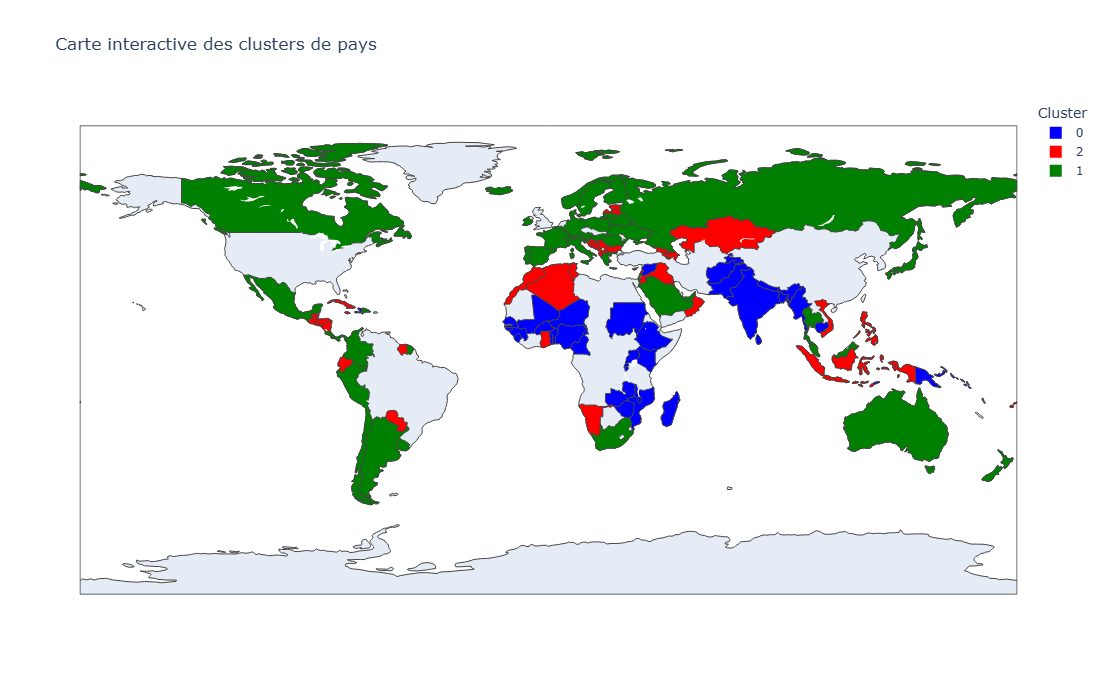

In [134]:
# carte plate
fig = px.choropleth(
    df_propre,
    locations="Country Name", 
    locationmode="country names",
    color="Cluster",
    hover_name="Country Name",
    title="Carte interactive des clusters de pays",
    color_discrete_map={
        "0": "blue",    # Cluster 0 → bleu
        "1": "green",   # Cluster 1 → vert
        "2": "red"      # Cluster 2 → rouge
    }
)

fig.update_layout(
    width=1200,  
    height=700   
)


fig.show()

# 2.4 Exemple d'un cas particuliers

In [74]:
df_propre[df_propre["Country Name"]=="Luxembourg"]

Country Name  GDP per capita (current US$)  GDP growth (annual %)  \
67   Luxembourg                 110193.213797               1.317188   

    GNI per capita, Atlas method (current US$  \
67                                    75800.0   

    Urban population (% of total population)  \
67                                    90.727   

    Access to electricity (% of population)  \
67                                    100.0   

    Individuals using the Internet (% of population)  population  \
67                                              97.4    596336.0   

    stabilite_politique  Export quantity_Meat  ...  \
67             1.312894                  11.0  ...   

    Organic area share of total farmland [%]  prod_volaille_par_hab  \
67                                      4.15                    0.0   

    ratio_export_import_viande  indice_numerique  log_ratio_export_import  \
67                    0.289474              98.7                 0.254234   

    log_gdp_per_capita  log_export_meat  log_production_poultry  Cluster_CAH  \
67               11.61         2.484907                     0.0            2   

    Cluster  
67        2  

[1 rows x 27 columns]

# Le Luxembourg est trop petit et peu actif dans le secteur avicole : pas de production, peu d’exportation, donc il ressemble davantage à des pays neutres ou non agricoles → ce qui explique sa présence dans Cluster 2.

# 3. Recommandations

cluster 2 : cible prioritaire
raisonnablement stable, bonne croissance, urbanisation en prograssion
moins saturé que le cluster 1
stratégie : tester l,export avec oartenaires locaux, marchés urbains, arguments bio


cluster 1 : opportunité complémentaire
marché mature, riche et digitalisé
peut préférer des produits haut de gamme, bio, éthique
stratégie :  image de marque, e-commerce, niches premium


cluster 0 : à éviter
risuqe politiques, faible pouvoir d'achat, infrastructures fragiles
stratégie : veille uniquement, pas d'investissement dierect pour l'instant

profil pays

cluster 2 : pays intermediaire ou atypique , hétérogene

cluster 1 : pays développés, structurés et haut de gamme

cluster 0 : pays à faible revenu, et faible production